In [2]:
import nappy.nappy_api
import pandas as pd 
# import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import calendar

In [3]:
adjusted_csv_path = os.path.join(os.getcwd(), 'final_adjusted_2011_2024.csv')

def adjusted_coefficients(csv_file):
    
    date = []
    starttime = []
    scattering_coeff = []
    absorption_coeff = []
    absorption_angstrom = []
    scattering_angstrom = []
    
    adjusted_csv = pd.read_csv(csv_file, header=0) 
    
    adjusted_csv.replace([99999.99, 9999.99, 999.999999, 999.99, 99.99, 9.999], np.NaN, inplace=True)    
    
    for selected_columns in adjusted_csv.columns:
        
        if selected_columns.startswith('pm1') or selected_columns.startswith('starttime') or selected_columns.startswith('Date'):

            if selected_columns.startswith('pm1'):

                variable = selected_columns.find('_') + 1
                
                selected_variable = selected_columns[variable: (variable + 10)]

                if selected_columns.startswith('pm1'):
                    
                    if selected_variable == 'scattering':

                        variable = selected_columns.find('angstrom')
                                    
                        if variable == -1:
                            scattering_coeff.append(selected_columns)
                            
                        else:
                            scattering_angstrom.append(selected_columns)
                
                    else: 
                        variable = selected_columns.find('angstrom')
                        
                        if variable == -1:
                            absorption_coeff.append(selected_columns)
                            
                        else:
                            absorption_angstrom.append(selected_columns)
                        
            elif selected_columns.startswith('starttime'):

                starttime.append(selected_columns)
                
            else:
                date.append(selected_columns)
                        
    return starttime, absorption_coeff, absorption_angstrom, scattering_coeff, scattering_angstrom, date, adjusted_csv
    
adjusted_coefficients(adjusted_csv_path)

(['starttime'],
 ['pm10_absorption_coeff_450',
  'pm10_absorption_coeff_550',
  'pm10_absorption_coeff_700',
  'pm1_absorption_coeff_450',
  'pm1_absorption_coeff_550',
  'pm1_absorption_coeff_700'],
 ['pm10_absorption_angstrom_450_550',
  'pm10_absorption_angstrom_450_700',
  'pm10_absorption_angstrom_550_700',
  'pm1_absorption_angstrom_450_550',
  'pm1_absorption_angstrom_450_700',
  'pm1_absorption_angstrom_550_700'],
 ['pm10_scattering_coeff_450',
  'pm10_scattering_coeff_550',
  'pm10_scattering_coeff_700',
  'pm1_scattering_coeff_450',
  'pm1_scattering_coeff_550',
  'pm1_scattering_coeff_700'],
 ['pm10_scattering_angstrom_450_550',
  'pm10_scattering_angstrom_450_700',
  'pm10_scattering_angstrom_550_700',
  'pm1_scattering_angstrom_450_550',
  'pm1_scattering_angstrom_450_700',
  'pm1_scattering_angstrom_550_700'],
 ['Date'],
         starttime                 Date  pm10_scattering_coeff_450  \
 0        24.00000  2011-01-24 00:00:00                       2.17   
 1        24.

In [18]:
def get_one_year(df, start_row):
    
    # Find the index of the first starttime for the next year after start_row
    end_row = -1
    prev_value = -1
    
    for index, value in enumerate(df['starttime'][start_row:]):
        if value < prev_value:
            end_row = start_row + index
            break
            
        prev_value = value
        
        
    if end_row < 0:
        end_row = start_row + len(df['starttime'][start_row:])
        
    # print('start_row: ' + str(start_row) + '; end_row: ' + str(end_row))
 
    return df[start_row:end_row] 

def monthly_averages(ave_day, year):
    monthly_avg = []
    
    for month in range(1, 13):
        
        month_name = calendar.month_name[month]
        days_in_month = calendar.monthrange(year, month)[1]
        
        month_data = ave_day.iloc[:days_in_month]
        
        month_avg = month_data[ave_day.columns[2:]].mean()
        
        month_avg_dict = month_avg.to_dict()
        month_avg_dict['month'] = month_name 
        
        monthly_avg.append(month_avg_dict)
        ave_day = ave_day.iloc[days_in_month:]

    monthly_avg_df = pd.DataFrame(monthly_avg)

    return monthly_avg_df


def aerosol_plots(columns):
    
    variable_columns = []
    
    dataframe = columns[6]
    
    new_dictionary = {
        'coefficients': {
            'scattering': columns[3], 
            'absorption': columns[1],
            },
        'starttime':columns[0]
    }
    
    for variable in new_dictionary['coefficients']:    
        
        for coefficient in new_dictionary['coefficients'][variable]:

            variable_columns.append(coefficient)
        
    for time in new_dictionary['starttime']:
        variable_columns.append(time)
        
    # return dataframe[variable_columns]
    
    # df = pd.DataFrame(dataframe[variable_columns]).dropna()
        
    # new_names = ['pm10_extinction450', 'pm10_extintion550', 'pm10_extinction700', 'pm1_extinction450', 'pm1_extinction550', 'pm1_extinction700']
        
    # for col in range(0,6):
    #     df[new_names[col]] =  df.iloc[:, col] / (df.iloc[:, col] + df.iloc[:, col+6])
        
    df = pd.DataFrame(dataframe[variable_columns]).dropna()

    new_names = ['pm10_extinction450', 'pm10_extintion550', 'pm10_extinction700',
                'pm1_extinction450', 'pm1_extinction550', 'pm1_extinction700']

    for col in range(0, 6):
        scattering = df.iloc[:, col]
        absorption = df.iloc[:, col + 6]
        total = scattering + absorption

        with np.errstate(divide='ignore', invalid='ignore'):
            df[new_names[col]] = np.where(total != 0, scattering / total, np.nan)
        
    # new_df = pd.concat([df.iloc[:, 0:6], df['starttime']], axis = 1)
    new_df = df.iloc[:, 12:]

    new_df['time_int'] = np.floor(new_df['starttime']).astype(int)
    # new_df = new_df.drop('starttime', axis=1)
    
    final_df = pd.DataFrame()
    
    year = 2011
    start_row = 0
    while start_row < len(new_df['starttime']):
    
        df = pd.DataFrame(get_one_year(new_df, start_row))
        
        if df.empty:
            start_row = len(new_df['starttime'])
            
        else:
            new_df['time_int'] = np.floor(new_df['starttime']).astype(int)
            # ave_day = new_df.groupby('time_int').agg({
            #     'pm10_extinction450': 'mean', 
            #     'pm10_extintion550': 'mean', 
            #     'pm10_extinction700': 'mean', 
            #     'pm1_extinction450': 'mean', 
            #     'pm1_extinction550': 'mean', 
            #     'pm1_extinction700': 'mean'}).reset_index()
            ave_day = new_df.groupby('time_int').mean().reset_index()
            # print(ave_day)
            monthly = monthly_averages(ave_day, year)
            # print(monthly)
            year += 1
            
            final_df = pd.concat([final_df, monthly])
            start_row = start_row + len(ave_day['time_int'])
            
    # for month in range(1:13):
    all_years = final_df.groupby('month', sort=False).mean().reset_index()
    # .groupby(['month','pm10_extinction450', 'pm10_extintion550', 'pm10_extinction700', 'pm1_extinction450', 'pm1_extinction550', 'pm1_extinction700']).mean().reset_index()
    
    new_columns = []
    
    for variables in all_years.columns:
        if variables == 'pm10_extintion550':
            new_columns.append(variables)
        elif variables == 'month':
            new_columns.append(variables)
    SPL_ssa_550 = pd.DataFrame(all_years[new_columns])
    SPL_ssa_550.rename(columns={'pm10_extintion550': 'SPL_ssa_550'}, inplace=True)

    # new_df = new_df.groupby('time_int')
    # ave_day = new_df.groupby('time_int')[new_df.columns[1:7]].mean().reset_index()       
    # ave_day = new_df.groupby('time_int')['pm10_extinction450', 'pm10_extintion550', 'pm10_extinction700', 'pm1_extinction450', 'pm1_extinction550', 'pm1_extinction700'].mean().reset_index()       
    return SPL_ssa_550
    # return new_df
    # return ave_day
    # all_years = final_df.groupby('month').mean().reset_index()
            
columns = adjusted_coefficients(adjusted_csv_path)
aerosol_plots(columns)
# print(df)

,month,SPL_ssa_550
0,January,0.851293
1,February,0.868561
2,March,0.891187
3,April,0.919180
4,May,0.930959
5,June,0.920748
6,July,0.924981
7,August,0.933381
8,September,0.926560
9,October,0.915430


In [24]:
columns = adjusted_coefficients(adjusted_csv_path)
spl_data = aerosol_plots(columns)

table_mountian_ssa = pd.read_csv('table_mountain_ssa')
table_mountian_ssa = pd.DataFrame(table_mountian_ssa)
table_mountian_ssa.drop('Unnamed: 0', axis = 1, inplace=True)
table_mountian_ssa.rename(columns={'pm10_extintion550': 'BOS_ssa_550'}, inplace=True)
merged_data_ssa = table_mountian_ssa.join(spl_data)
merged_data_ssa

,BOS_ssa_550,month,SPL_ssa_550
0,0.845575,January,0.851293
1,0.859772,February,0.868561
2,0.881831,March,0.891187
3,0.882268,April,0.919180
4,0.876622,May,0.930959
5,0.874754,June,0.920748
6,0.898655,July,0.924981
7,0.899298,August,0.933381
8,0.877650,September,0.926560
9,0.853520,October,0.915430


In [25]:
# def monthly_plot(monthly_avg_df):
        
#     # key = ['PM10 450nm', 'PM10 550nm', 'PM10 700nm', 'PM1 450nm', 'PM1 550nm', 'PM1 700nm',]
#     key = ['PM10 550nm', 'PM1 550nm']


#     plt.figure(figsize=(10,6))

#     # Loop through the first three columns to plot each one separately
#     for i, col in enumerate(monthly_avg_df.columns[1:7]):
        
#         # if col == 'pm10_extinction450':
#         #     plt.plot(monthly_avg_df['month'], monthly_avg_df[col], label=key[i], marker='d', linestyle='dotted', color='darkblue')
            
#         if col == 'pm10_extintion550':
#             plt.plot(monthly_avg_df['month'], monthly_avg_df[col], label=key[0], marker='d', linestyle='dotted', color='darkgreen')
            
            
#         # elif col == 'pm10_extinction700':
#         #     plt.plot(monthly_avg_df['month'], monthly_avg_df[col], label=key[i], marker='d', linestyle='dotted', color='crimson')
            
#         # elif col == 'pm1_extinction450':
#         #     plt.plot(monthly_avg_df['month'], monthly_avg_df[col], label=key[i], marker='d', color='blue')
            
#         # elif col == 'pm1_extinction550':
#         #     plt.plot(monthly_avg_df['month'], monthly_avg_df[col], label=key[i], marker='d', color='green')
            
#         # else:
#         #     plt.plot(monthly_avg_df['month'], monthly_avg_df[col], label=key[i], marker='d', color='red')   
            
#         # if i >= 3:
#         #     # Different style for this specific column
#         #     plt.plot(monthly_avg_df['month'], monthly_avg_df[col], label=key[i], marker='d', linestyle='dotted')
            
#         # else:
#         #     plt.plot(monthly_avg_df['month'], monthly_avg_df[col], label=key[i], marker='d')
            
#         # plt.errorbar(monthly_avg_df['month'], monthly_avg_df[col])
#     # plt.title(f'Single scattering albedo from {start_date} to {end_date} at Storm Peak Laboratory', fontsize=15)
#     # plt.title(f'Single Scattering Albedo', fontsize=15)
#     plt.legend(key, bbox_to_anchor=(1, 1), loc='upper right')
#     # plt.xlabel('Month', fontsize=15)
#     plt.ylabel('Single Scattering Albedo (550 nm, Mm$^-$$^1$)', fontsize=15)
#     plt.xticks(rotation=45)
#     plt.grid()
#     plt.show()
#     plt.close()

# columns = adjusted_coefficients(adjusted_csv_path)
# plots = aerosol_plots(columns)
# # d = monthly_averages(plots)
# monthly_plot(plots)

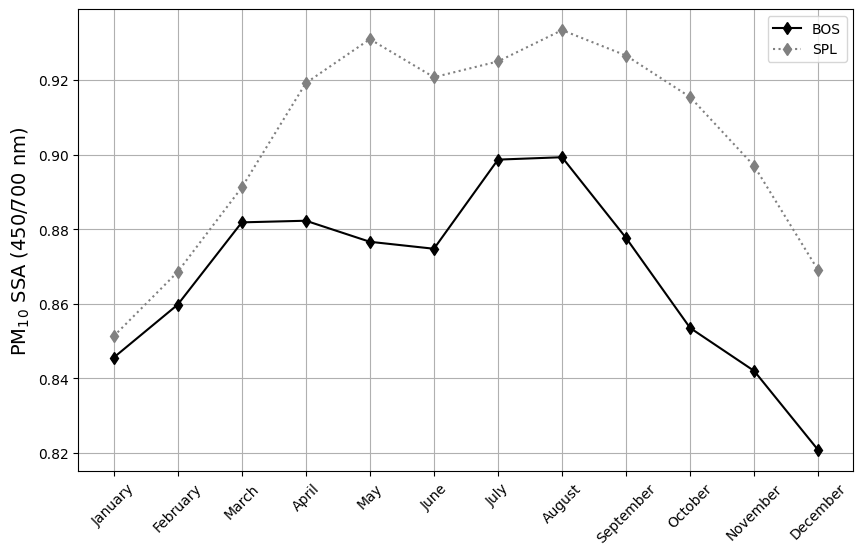

In [26]:
def monthly_plot(monthly_avg_df):

    key = ['SPL', 'BOS']
    
    plt.figure(figsize=(10,6))

    for col in monthly_avg_df.columns:
        if col.startswith('BOS'):
            plt.plot(monthly_avg_df['month'], monthly_avg_df[col], label=key[1], marker='d', color='black')
            
        elif col.startswith('SPL'):
            plt.plot(monthly_avg_df['month'], monthly_avg_df[col], label=key[0], marker='d', linestyle='dotted', color='grey')
            
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right')
    # plt.xlabel('Month', fontsize=14)
    plt.ylabel(f'PM$_1$$_0$ SSA (550 nm)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
    plt.close()

monthly_plot(merged_data_ssa)